In [2]:
from collections import namedtuple
from functools import partial
import matplotlib.pyplot as plt
%matplotlib inline

from pprint import pprint
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

# Metropolis-within-Gibbs sampling with Tensorflow Probability

Markov-chain Monte Carlo, or MCMC, is a powerful methodology for simulating draws from 
a random variable $X$, for which a probability density function $\pi(X)$ is known only up to a 
normalising constant.  It is often used to sample from Bayesian posterior distributions, expecially
when the probability space is complex.

Let us start with a simple example, considering a Bayesian changepoint model in which our data observations 
$y_t, \; t=1,\dots,T$ are discrete in time and Poisson distributed such that

$$
y_t \sim \mbox{Poisson}(e^{\eta_t})
$$

where

$$
\eta_t = \begin{cases}
  \alpha_0 & \mbox{if } t \leq s \\
  \alpha_1 & \mbox{if } t > s \\
\end{cases}.
$$

Here, $s$ is an unknown changepoint denoting the point at which the Poisson mean changes from $\alpha_0$ to $\alpha_1$.

## The data generating model

Let's first simulate a dataset from this model, using $T=20$, $\alpha_0 = 1.1$, $\alpha_1 = 2.5$, and $s=10$:

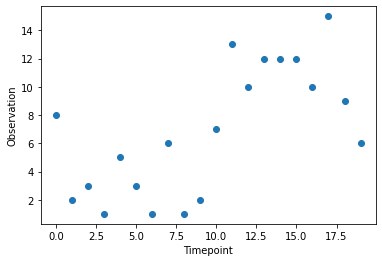

In [4]:
def data_generating_model(alpha_0, alpha_1, s, T):
    """Simulate a draw from a changepoint model
    
    Args:
      alpha0: first log mean
      alpha1: second log mean
      s: the changepoint
      T: number of timepoints
    
    Returns:
      a tensor of observations
    """
    t = tf.range(T)
    eta = tf.where(t <= s, alpha_0, alpha_1)
    return tfd.Poisson(rate=tf.math.exp(eta)).sample()

y_sim = data_generating_model(alpha_0=1.1, alpha_1=2.5, s=10, T=20)
plt.plot(y_sim, "o")
plt.ylabel("Observation")
_ = plt.xlabel("Timepoint")

Now suppose that we impose prior distributions on $\alpha_0, \alpha_1 \sim \mbox{Normal}(0, 10)$ and $s \sim \mbox{Discrete}(1,\dots,T)$.  This allows us to define the log posterior density function
$$
\ell(y; \alpha_0, \alpha_1, s) = \sum_{t=1}^{T} \left(\log f(y_t | \alpha_0, \alpha_1, s)\right) + \log f(\alpha_0) + \log f(\alpha_1) + \log f(s)
$$

In [5]:
def model_log_prob_fn(alpha_0, alpha_1, s, y):

    num_times = y.shape[0]
    
    # Priors
    lf_alpha_0 = tfd.Normal(loc=0.0, scale=10.0).log_prob(alpha_0)
    lf_alpha_1 = tfd.Normal(loc=0.0, scale=10.0).log_prob(alpha_1)
    lf_s = tf.where((0 <= s) & (s < num_times), 0.0, -np.inf) # uniform density

    # Likelihood
    t = tf.range(num_times, dtype=tf.int32)
    eta = tf.where(t <= s, alpha_0, alpha_1)
    lf_y = tf.reduce_sum(tfd.Poisson(rate=tf.math.exp(eta)).log_prob(y))

    log_prob = lf_y + lf_alpha_0 + lf_alpha_1 + lf_s
    
    return log_prob

## Inference

Our model poses a problem for MCMC sampling in that our parameter space $\theta = \{\alpha_0, \alpha_1, s\}$
contains both continuous ($\alpha_0$ and $\alpha_1$) and discrete ($s$) random variables, such that a single MCMC kernel
(e.g. multi-site random walk Metropolis-Hastings or Hamiltonian Monte Carlo) is not suitable.  Fortunately, the "Metropolis-within-Gibbs" flavour of
MCMC provides for this situation by allowing us to decompose the parameter space into sub-spaces on which
different kernels can operate.

Let us suppose we have two kernels

$$
k_\alpha(\alpha_0, \alpha_1; \pi_\alpha(\cdot | s, y)) :: (\alpha_0, \alpha_1) \rightarrow (\alpha_0^\prime, \alpha_1^\prime)
$$

and 

$$
k_s(s; \pi_s(\cdot | \alpha_0, \alpha_1, y)) :: s \rightarrow s^\prime
$$

for which the conditional posterior distribution functions are $\pi_\alpha(\alpha_0, \alpha_1 | s, y)$ and $\pi_s(s | \alpha_0, \alpha_1, y)$ respectively.
From a computer science perspective, both $\pi_\alpha$ and $\pi_s$ may be thought of as [_partial function evaluations_](https://en.wikipedia.org/wiki/Partial_application)
of the joint posterior density function $\pi(\alpha_0, \alpha_1, s | y)$ as described above.  

Given parameter vector $(\alpha_0, \alpha_1, s)$, one step of the overall MCMC algorithm would go something like:

1. Draw $(\alpha_0^\prime,\alpha_1^\prime) \sim k_\alpha(\alpha_0, \alpha_1; \pi_\alpha(\cdot | s, y))$
2. Draw $s^\prime \sim k_s(s ; \pi_s(\cdot | \alpha_0^\prime, \alpha_1^\prime, y))$
3. Return $\alpha_0^\prime, \alpha_1^\prime, s^\prime$

In terms of the overal parameter vector then, the crucial aspect of this algorithm is that Step 1 maps $(\alpha_0, \alpha_1, s) \mapsto (\alpha_0^\prime, \alpha_1^\prime, s)$, and Step 2 maps $(\alpha_0^\prime, \alpha_1^\prime, s) \mapsto (\alpha_0^\prime, \alpha_1^\prime, s^\prime)$.  Thus $k_2$ _depends_ on $\alpha_0^\prime$ and $\alpha_1^\prime$ drawn in Step 1 through the definition of the conditional posterior $\pi_s$.  This sequential application of _partial kernels_ has implications for how we implement our MCMC sampler in code.

__Note__: We are going to make a _lot_ of use of partial function evaluation. If you're unfamiliar with [closures](https://en.wikipedia.org/wiki/Closure_(computer_programming)) or Python's [functools.partial](https://docs.python.org/3/library/functools.html), then dip out for 5 minutes and read up on it!

### The sampler

We will now provide a concrete example of a Metropolis-within-Gibbs MCMC algorithm, in which we assume $k_1$ is an adaptive Hamiltonian Monte Carlo (HMC) algorithm, and $k_2$ is a discrete random-walk Metropolis-Hastings algorithm.  What follows is intended to be a simple software pattern, bespoke to this MCMC scheme but that demonstrates how partial kernels are instantiated on-the-fly by creating ephemeral conditional log density functions.  The pattern should not be considered a particularly re-usable software device, but could definitely be built into a more generic Metropolis-within-Gibbs framework.

#### Preliminaries
We first begin by defining a `namedtuple` to hold the current MCMC chain state, i.e. $(\alpha_0, \alpha_1, s)$

In [6]:
State = namedtuple("State", ["alpha_0", "alpha_1", "s"])

and then condition our model on the observed data, using partial function evaluation to obtain a computation representing the joint log posterior distribution function

In [7]:
joint_log_posterior_fn = partial(
    model_log_prob_fn, y=y_sim
)
joint_log_posterior_fn(alpha_0=1.0, alpha_1=2.0, s=10)

<tf.Tensor: shape=(), dtype=float32, numpy=-61.33996>

#### Kernel construction

We now define two _kernel builder_ functions which return `tfp.mcmc.TransitionKernel` objects designed to operate on our parameter subsets.  Each builder function takes the global MCMC chain state, builds a conditional distribution function by closing over the "fixed" portion of the global state, and then instantiates and returns the kernel.  Note the presence also of the bespoke discrete random walk proposal function `discrete_random_walk_proposal_fn`.

In [8]:
def make_alpha_kernel(current_state):
    
    def conditional_log_prob_fn(alpha_0, alpha_1):
        return joint_log_posterior_fn(alpha_0, alpha_1, current_state.s)
    
    return tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=conditional_log_prob_fn,
        step_size=0.1,
        num_leapfrog_steps=16
    )


def discrete_random_walk_proposal_fn(max_delta):
    """A function that implements a discrete Uniform random walk proposal
    
    Args:
        max_delta: the maximum distance for a random walk step
    Returns:
        a function with signature `fn(x, seed)` which returns a 
        new `x` shifted by a discrete increment in the range 
        `[x-max_delta, x+max_delta]`.
    """

    def new_state_fn(x, seed):
        """Discrete random walk"""
        if isinstance(x, (tuple, list)):
            x_ = x[0]

        proposed_state = x_ + tf.cast(
            tf.math.floor(
                tfd.Uniform(low=-max_delta, high=max_delta).sample(seed=seed)
            ),
            dtype=tf.int32,
        )

        if isinstance(x, (tuple, list)):
            proposed_state = [proposed_state]

        return proposed_state
    
    return new_state_fn


def make_s_kernel(current_state):
    
    def conditional_log_prob_fn(s):
        return joint_log_posterior_fn(
            current_state.alpha_0, current_state.alpha_1, s
        )
    
    return tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=conditional_log_prob_fn,
        new_state_fn=discrete_random_walk_proposal_fn(3),
    )

#### Combining the kernels

We then combine the kernels into a "compound kernel", complete with the logic that runs the computations.  For each kernel, we:

1. instantiate the TFP kernel object, 
2. initialise the kernel "results" structure using the `bootstrap_results` method (which computes the "current" value of the conditional posterior), 
3. invoke the `one_step` method to actually run the transition kernel.
4. Update the state `namedtuple`

In [9]:
def compound_kernel(current_state, seed=None):
    """Execute the compound kernel
    
    Args:
      current_state: a namedtuple encapsulating the MCMC chain state
    
    Returns:
      a tuple of `(new_state, new_results)`
    """
    ### Split seed
    seeds = tfp.random.split_seed(seed, n=2, salt="compound_kernel")
    
    ### Build and execute k_\alpha
    kernel_alpha = make_alpha_kernel(current_state)
    
    current_alpha = (current_state.alpha_0, current_state.alpha_1) # Pack for convenience
    results_alpha = kernel_alpha.bootstrap_results(current_alpha)
    
    new_alpha, new_results_alpha = kernel_alpha.one_step(
        current_state=current_alpha,
        previous_kernel_results=results_alpha,
        seed=seeds[0],
    )
    
    # Update state
    next_state = current_state._replace(alpha_0=new_alpha[0], alpha_1=new_alpha[1])

    ### Build and execute k_s
    kernel_s = make_s_kernel(next_state)

    results_s = kernel_s.bootstrap_results(next_state.s)
    
    new_s, new_results_s = kernel_s.one_step(
        current_state=next_state.s,
        previous_kernel_results=results_s,
        seed=seeds[1],
    )
    
    # Update state
    final_state = next_state._replace(s=new_s)
    
    return final_state, (new_results_alpha, new_results_s)

#### Testing the compound kernel

Let's quickly test the compound kernel, and study the structure of the function output.  Importantly, we see that the `results` structure is a tuple containing two instances of `MetropolisHastingsKernelResults`, which contain various interesting statistics about the kernels applied to the parameter vector.

In [11]:
new_state, results = compound_kernel(State(1.0, 2.0, 10))
print("new_state:")
pprint(new_state)
print("results:")
pprint(results)

new_state:
State(alpha_0=<tf.Tensor: shape=(), dtype=float32, numpy=1.1843501>, alpha_1=<tf.Tensor: shape=(), dtype=float32, numpy=2.4595327>, s=<tf.Tensor: shape=(), dtype=int32, numpy=10>)
results:
(MetropolisHastingsKernelResults(
  accepted_results=UncalibratedHamiltonianMonteCarloKernelResults(
      log_acceptance_correction=<tf.Tensor: shape=(), dtype=float32, numpy=-6.1093855>,
      target_log_prob=<tf.Tensor: shape=(), dtype=float32, numpy=-53.514496>,
      grads_target_log_prob=[<tf.Tensor: shape=(), dtype=float32, numpy=3.0339744>, <tf.Tensor: shape=(), dtype=float32, numpy=-6.3186884>],
      initial_momentum=[<tf.Tensor: shape=(), dtype=float32, numpy=1.779703>, <tf.Tensor: shape=(), dtype=float32, numpy=1.250512>],
      final_momentum=[<tf.Tensor: shape=(), dtype=float32, numpy=-2.2814403>, <tf.Tensor: shape=(), dtype=float32, numpy=-3.4270868>],
      step_size=[],
      num_leapfrog_steps=[],
      seed=[]
    ),
  is_accepted=<tf.Tensor: shape=(), dtype=bool, numpy=

### Running the MCMC algorithm

To generate a useful MCMC chain, we must call `compound_kernel` recursively as many times as we need
to draw samples from the posterior.  Again, there are various ways to do this, but I've chosen to use
`tf.scan` here:

In [12]:
@tf.function(jit_compile=True)
def run_mcmc(initial_state, num_samples, seed):

    def scan_fn(state_and_results, seed):
        state, _ = state_and_results
        return compound_kernel(state, seed)
    
    seeds = tfp.random.split_seed(
        seed,
        n=num_samples,
        salt="run_mcmc",
    )

    # Make the initial results structure
    initial_results = (
        make_alpha_kernel(initial_state).bootstrap_results(
            (initial_state.alpha_0, initial_state.alpha_1)
        ),
        make_s_kernel(initial_state).bootstrap_results(initial_state.s),
    )
    
    return tf.scan(
        fn=scan_fn,
        elems=tf.stack(seeds),
        initializer=(initial_state, initial_results),
    )
    
    

#### Run the MCMC

We now run the MCMC from a fixed starting position, and with a constant seed for reproducibility.  The acceptance rates of both kernels are outputted below.

In [14]:
samples, results = run_mcmc(
    State(alpha_0=1.0, alpha_1=3.0, s=5),
    num_samples=10000,
    seed=[0,1],
)

print("kernel_alpha acceptance:", np.mean(results[0].is_accepted))
print("kernel_s acceptance:", np.mean(results[1].is_accepted))

kernel_alpha acceptance: 0.9093
kernel_s acceptance: 0.2754


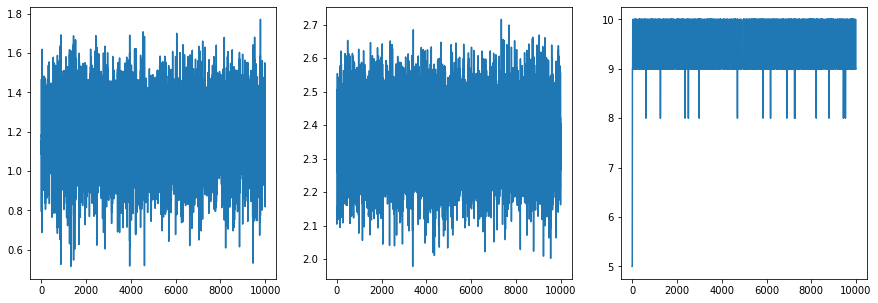

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

ax[0].plot(samples.alpha_0)
ax[1].plot(samples.alpha_1)
ax[2].plot(samples.s)

## Further enhancements for the next tutorial

1. The algorithm above uses a fixed step-size HMC kernel.  In practice, we would want to use an adaptive HMC kernel which will require making use of the HMC `results` structure from the previous `compound_kernel` invocation.  We do this so that we can forward all the adaptive metrics used to set both the step-size, and ultimately the mass matrix too.
2. `compound_kernel` calls `bootstrap_results` before `one_step` for each kernel in the MCMC scheme.  This is potentially a waste of computing resource, since the `target_log_prob` field could be cached between the two kernel `results` structures, obviating the need for computation of both the "current" and "proposed" target densities in the Metropolis-Hastings accept/reject ratio.  
